# 06. PyTorch Transfer Learning Exercises

### 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.

In [9]:
import torch
import torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchinfo import summary

from going_modular import data_setup, engine

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_steak_sushi directory exists.


In [12]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x23450a22dd0>,
 ['pizza', 'steak', 'sushi'])

In [14]:
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
model_0

c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
# Freezing the base layers
for param in model_0.features.parameters():
    param.requires_grad = False

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_0.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=output_shape,
              bias=True)
).to(device)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.9015 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9304 | train_acc: 0.5547 | test_loss: 0.7984 | test_acc: 0.6932
Epoch: 3 | train_loss: 0.8171 | train_acc: 0.6953 | test_loss: 0.6695 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7350 | train_acc: 0.7617 | test_loss: 0.6444 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6784 | train_acc: 0.7656 | test_loss: 0.6367 | test_acc: 0.9072
[INFO] Total training time: 137.95 seconds


In [19]:
# Making predictions on our entire test dataset
from tqdm.auto import tqdm

test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    test_logits = model_0(X)
    pred_probs = torch.softmax(test_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    test_preds.append(pred_labels)
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:01<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [23]:
# Getting truth labels
test_truth = torch.cat([y for X, y in test_dataloader])     # Get each label (y) for all the samples in the test set
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [24]:
import torchmetrics, mlxtend

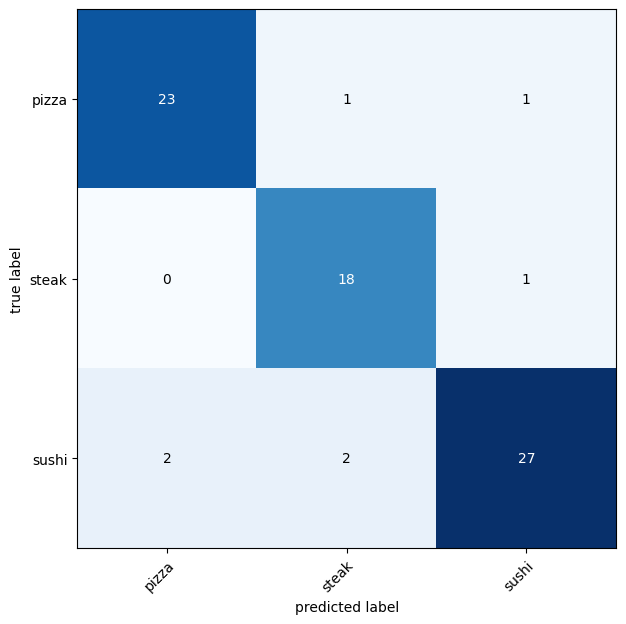

In [27]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="MULTICLASS")
confmat_tensor = confmat(preds=test_preds, target=test_truth)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7))

### 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images.

In [29]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

  0%|          | 0/75 [00:00<?, ?it/s]

In [31]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)

# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()    # Get the top 5 most wrong predictions. We sort by correct in ascending order and pred_prob in descending order
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
70,data\pizza_steak_sushi\test\sushi\684266.jpg,sushi,0.550160,steak,False
57,data\pizza_steak_sushi\test\sushi\2394442.jpg,sushi,0.478928,pizza,False
44,data\pizza_steak_sushi\test\sushi\1172255.jpg,sushi,0.453675,steak,False
34,data\pizza_steak_sushi\test\steak\27415.jpg,steak,0.452793,sushi,False
51,data\pizza_steak_sushi\test\sushi\175783.jpg,sushi,0.403816,pizza,False


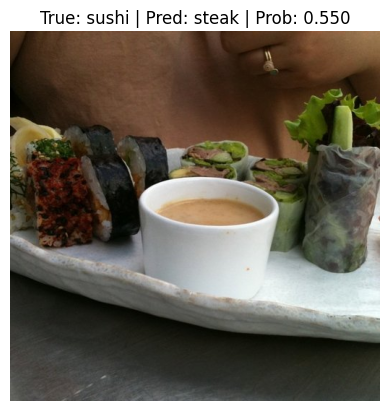

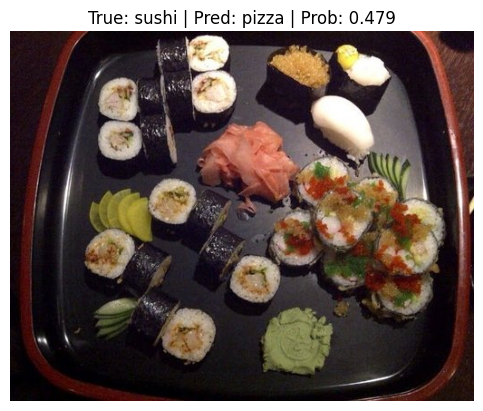

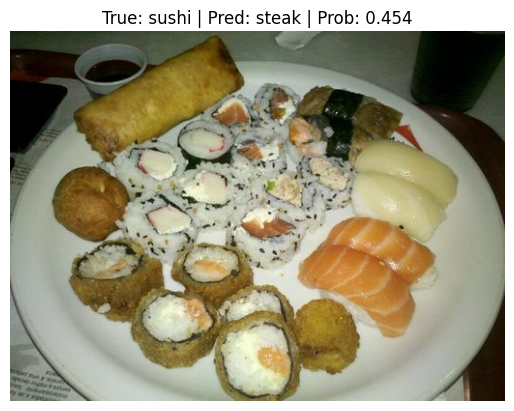

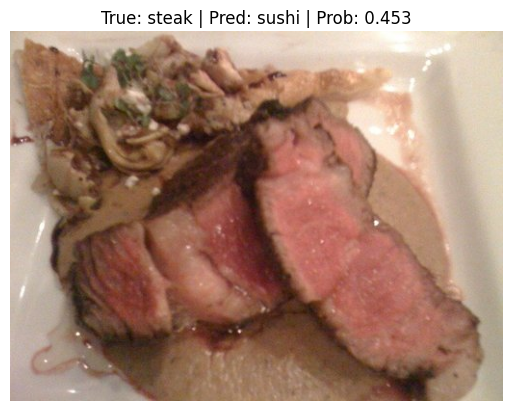

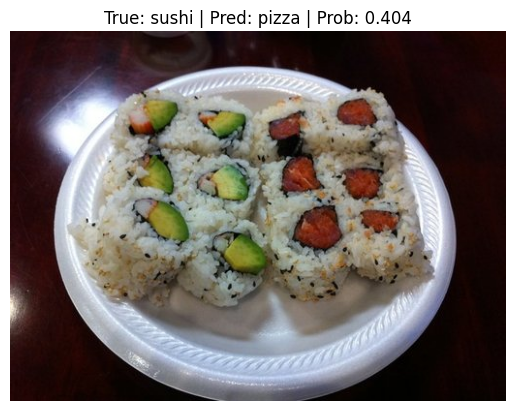

In [32]:
for row in top_5_most_wrong.iterrows():
    row = row[1]
    image_path = row[0]
    true_label = row[1]
    pred_prob = row[2]
    pred_class = row[3]
    # Plot the image and various details
    img = torchvision.io.read_image(str(image_path)) 
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))      # matplotlib likes images in [height, width, color_channels]
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
    plt.axis(False);

### 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

In [35]:
import requests
from PIL import Image
import shutil

url = "https://images.unsplash.com/photo-1588315029754-2dd089d39a1a"
response = requests.get(url, stream=True)

if response.status_code == 200:
    with open("photo.jpg", 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    print("Image downloaded successfully.")
else:
    print("Failed to download the image.")

shutil.move("photo.jpg", "pizza.jpg")

with Image.open("pizza.jpg") as img:
    # Reduce the image size and width
    (width, height) = (img.width // 10, img.height // 10)
    img_resized = img.resize((width, height))

img_resized.show()

Image downloaded successfully.


KeyboardInterrupt: 

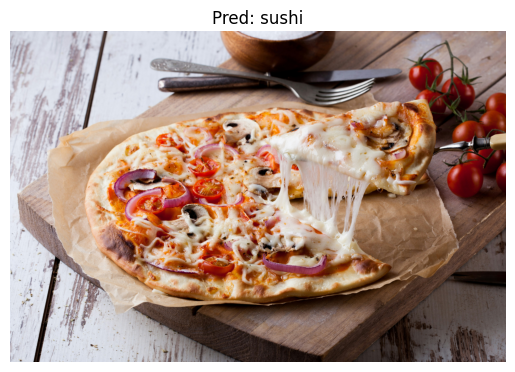

In [36]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)
  
  # plot image and pred
  plt.figure() 
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

### 4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [38]:
import torchvision 
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Create loss and optimizer 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1033 | train_acc: 0.3789 | test_loss: 0.8906 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6445 | test_loss: 0.8079 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7611 | train_acc: 0.8945 | test_loss: 0.6431 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7602 | train_acc: 0.6992 | test_loss: 0.5840 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6309 | train_acc: 0.8867 | test_loss: 0.6012 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5914 | train_acc: 0.7969 | test_loss: 0.5537 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5783 | train_acc: 0.8086 | test_loss: 0.5753 | test_acc: 0.8665
Epoch: 8 | train_loss: 0.5109 | train_acc: 0.7930 | test_loss: 0.4982 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4713 | train_acc: 0.9297 | test_loss: 0.5072 | test_acc: 0.9072
Epoch: 10 | train_loss: 0.5388 | train_acc: 0.8047 | test_loss: 0.5333 | test_acc: 0.9176
[INFO] Total training time: 287.249 seconds


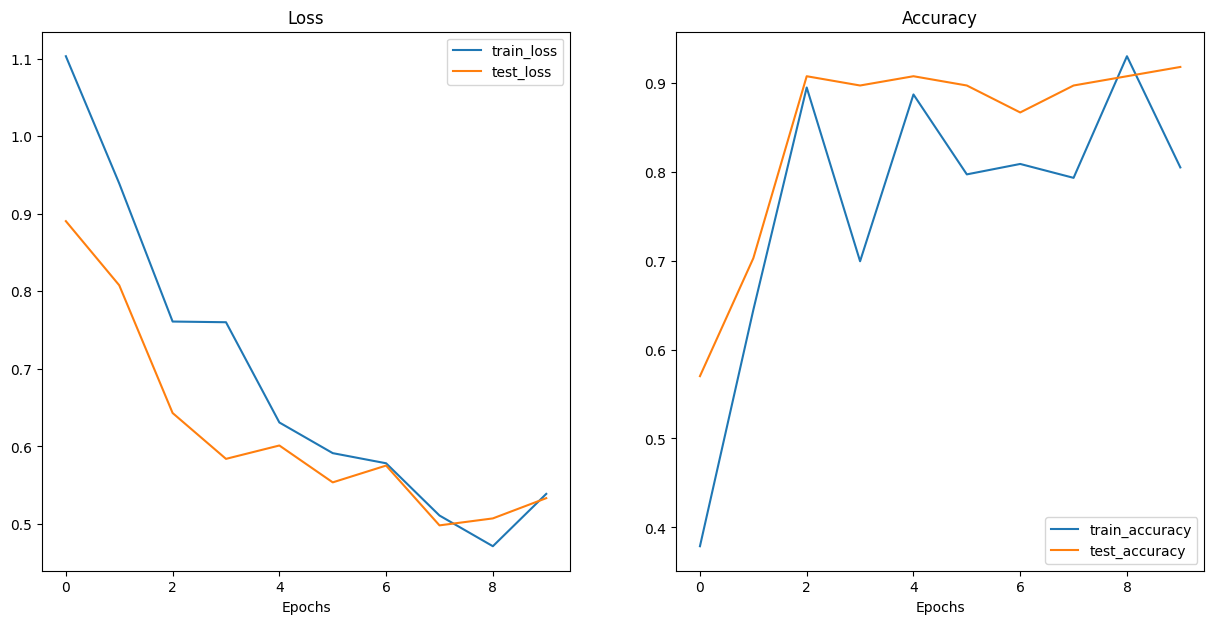

In [40]:
from helper_functions import plot_loss_curves
plot_loss_curves(model_1_results)

We get better accuracy but the model starts to overfit towards the end.

### 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.

In [41]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [42]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [43]:
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                        test_dir=test_dir_20_percent,
                                        transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                        batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x234761dba90>,
 ['pizza', 'steak', 'sushi'])

In [44]:
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all the base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device) 

c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader_20_percent,
                              test_dataloader=test_dataloader_20_percent,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9913 | train_acc: 0.5521 | test_loss: 0.6565 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.7156 | train_acc: 0.7937 | test_loss: 0.5414 | test_acc: 0.8943
Epoch: 3 | train_loss: 0.5648 | train_acc: 0.8521 | test_loss: 0.4511 | test_acc: 0.9006
Epoch: 4 | train_loss: 0.4661 | train_acc: 0.9042 | test_loss: 0.4053 | test_acc: 0.8915
Epoch: 5 | train_loss: 0.4526 | train_acc: 0.8708 | test_loss: 0.3743 | test_acc: 0.9006
[INFO] Total training time: 200.741 seconds


In [46]:
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])         # Getting the best results

(0.9071969696969697, 0.6366610725720724)

### 6. Try a different model from torchvision.models on the Pizza, Steak, Sushi data, how does this model perform?

Trying `efficientnet_b2()`

In [47]:
# Create a transform to transform the data
from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
  transforms.Resize((288, 288)), # effnet_b2 takes images of size 288, 288
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [48]:
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                            test_dir=test_dir,
                                                            transform=effnet_b2_transform,
                                                            batch_size=32)

In [49]:
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# Freeze the base layers
for param in model_3.parameters():
  param.requires_grad = False

# Change the classifier head (to suit our problem)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

c:\Users\Vansh\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\Vansh/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:01<00:00, 20.4MB/s]


In [50]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b2,
                              test_dataloader=test_dataloader_effnet_b2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1039 | train_acc: 0.3477 | test_loss: 0.9379 | test_acc: 0.6307
Epoch: 2 | train_loss: 0.9083 | train_acc: 0.5898 | test_loss: 0.8722 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7391 | train_acc: 0.8633 | test_loss: 0.7607 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.7964 | train_acc: 0.7227 | test_loss: 0.7237 | test_acc: 0.7955
Epoch: 5 | train_loss: 0.6825 | train_acc: 0.7695 | test_loss: 0.6749 | test_acc: 0.9280
[INFO] Total training time: 210.744 seconds


`efficientnet_b2()` takes longer to train but gives us better accuracy than `efficientnet_b0`